Estimation error analysis
=========================

_1 August 2021_ <br />
_Chuan-Zheng Lee <czlee@stanford.edu>_ <br />
_Rough working_

This is an effort to analyse whether a reduction in estimation error is in fact responsible for an improvement in learning.

In [1]:
import json
import numpy as np
import pandas as pd
import re
from pathlib import Path

import matplotlib.pyplot as plt

from plots_utils import plot_averaged_training_charts, plot_comparison, show_timestamp_info

In [2]:
analog_path = Path("results/20210730-estimation-error-dynpower")
digital_path = Path("results/20210730-estimation-error-dynquant")

In [3]:
show_timestamp_info(analog_path)

| experiments in this directory | started at | finished at | duration |
|--:|:-:|:-:|--:|
| first to start | **30 Jul 2021, 06:00:03** | 30 Jul 2021, 06:51:42 | 51 min 38 s |
| last to finish | 30 Jul 2021, 06:51:42 | **30 Jul 2021, 07:43:10** | 51 min 27 s |
| shortest | 30 Jul 2021, 06:51:42 | 30 Jul 2021, 07:43:10 | **51 min 27 s** |
| longest | 30 Jul 2021, 06:00:03 | 30 Jul 2021, 06:51:42 | **51 min 38 s** |


# First inspection

Analog:

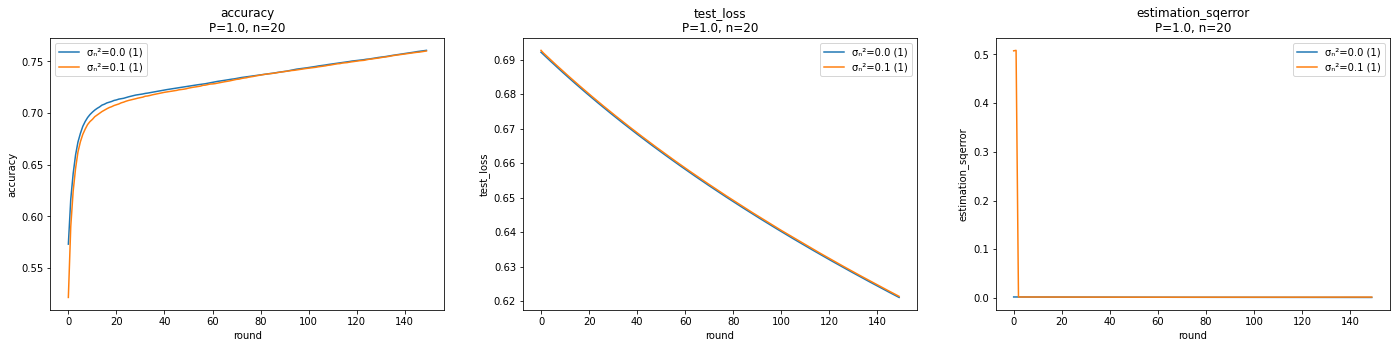

In [4]:
fixed_specs = {
    'rounds': 150,
    'batch_size': 64,
    'lr_client': 0.01,
    'momentum_client': 0.0,
    'epochs': 1,
    'dataset': 'epsilon',
    'ema_coefficient': 1 / 3,
    'power_update_period': 1,
    'power_quantile': 0.9,
    'power_factor': 0.9,
    'data_per_client': None,
    'save_squared_error': True,
    'send': 'deltas',
}
title_specs = {
    'power': 1.0,
    'clients': 20,
}
series_specs = {
    'noise': '__all__',
}
fields = ['accuracy', 'test_loss', 'estimation_sqerror']

plot_averaged_training_charts(analog_path, fields, title_specs, fixed_specs, series_specs)

(0.0, 0.003)

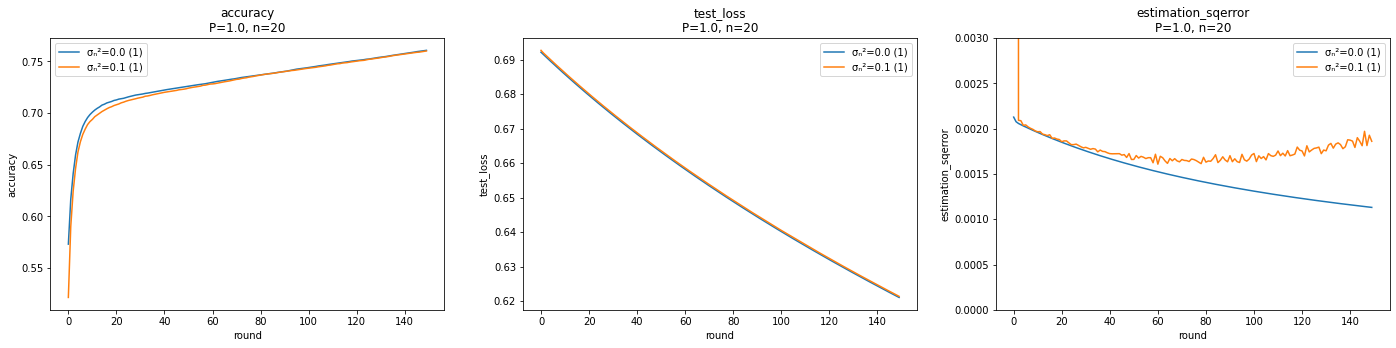

In [5]:
plot_averaged_training_charts(analog_path, fields, title_specs, fixed_specs, series_specs)
plt.ylim((0.0, 0.003))

Digital:

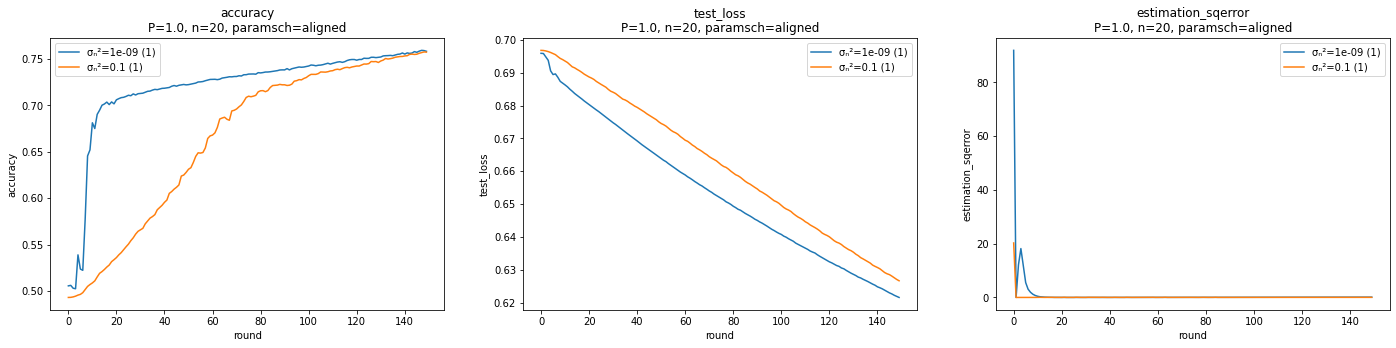

In [6]:
fixed_specs = {
    'rounds': 150,
    'batch_size': 64,
    'lr_client': 0.01,
    'momentum_client': 0.0,
    'epochs': 1,
    'dataset': 'epsilon',
    'ema_coefficient': 1 / 3,
    'qrange_update_period': 1,
    'qrange_param_quantile': 0.9,
    'qrange_client_quantile': 0.9,
    'data_per_client': None,
    'channel_uses': None,
    'rounding_method': 'stochastic',
    'zero_bits_strategy': 'read-zero',
    'send': 'deltas',
    'save_squared_error': True,
}
title_specs = {
    'power': 1.0,
    'clients': 20,
    'parameter_schedule': 'aligned',
}
series_specs = {
    'noise': '__all__',
}
fields = ['accuracy', 'test_loss', 'estimation_sqerror']

plot_averaged_training_charts(digital_path, fields, title_specs, fixed_specs, series_specs)

(0.0, 0.15)

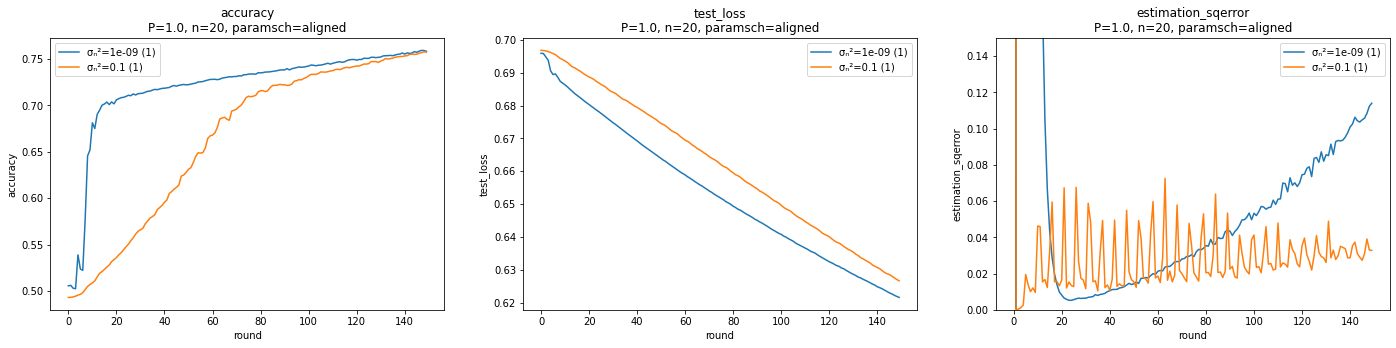

In [7]:
plot_averaged_training_charts(digital_path, fields, title_specs, fixed_specs, series_specs)
plt.ylim((0, 0.15))

Observations:

1. The estimation error for the digital scheme is in fact higher. I wouldn't necessarily call the correlation between loss reduction and estimation error one-to-one, but you also wouldn't necessarily expect it to be.

2. For some reason, whenever there is nonzero noise, the estimation error in the first two rounds—and only the first two rounds—is much higher than the third round onwards. But we can also see that when there is zero noise in the analog scheme, this error drops to zero. Why does this phenomenon occur _only_ with the first two rounds?

In [8]:
def get_model_params(directory):
    model_params = pd.DataFrame(index=range(150), columns=list(range(2000)) + ['weight_norm', 'bias'])
    for child in directory.iterdir():
        m = re.match("model_at_(\d+).json", child.name)
        if not m:
            continue
        with open(child) as f:
            model_dict = json.load(f)
        r = int(m.group(1))
        weights = np.array(model_dict['stack.0.weight']).flatten()
        norm = np.linalg.norm(weights, ord=2)
        bias = model_dict['stack.0.bias'][0]
        model_params.loc[r] = np.concatenate((weights, [norm, bias]))
    return model_params

<AxesSubplot:title={'center':'analog'}, xlabel='round'>

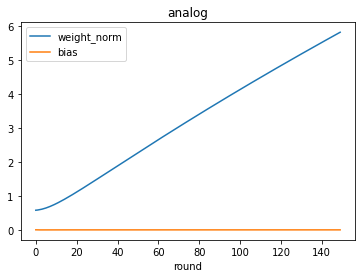

In [9]:
model_params_nonoise = get_model_params(analog_path / "20210730-054916" / "clients-20-noise-0.0-iteration-0")
model_params_nonoise[['weight_norm', 'bias']].plot(title="analog", xlabel="round")

<AxesSubplot:title={'center':'analog'}, xlabel='round'>

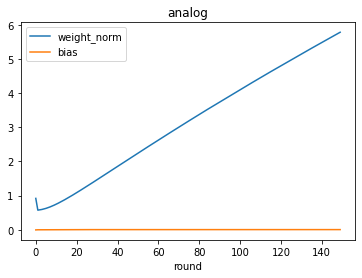

In [10]:
model_params_withnoise = get_model_params(analog_path / "20210730-054916" / "clients-20-noise-0.1-iteration-0")
model_params_withnoise[['weight_norm', 'bias']].plot(title="analog", xlabel="round")

<AxesSubplot:>

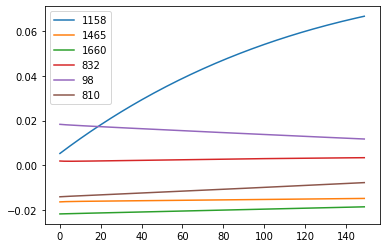

In [11]:
# I drew these indices randomly using `random.sample(range(2000), 6)`
# but fix them here so that rerunning doesn't change the plot.
indices = [1158, 1465, 1660, 832, 98, 810]
model_params_nonoise[indices].plot()

<AxesSubplot:>

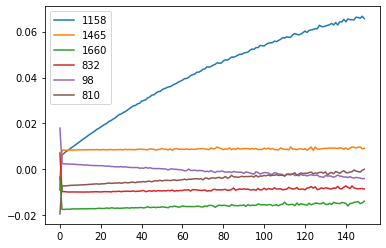

In [12]:
model_params_withnoise[indices].plot()

Does this happen with every parameter?

<AxesSubplot:>

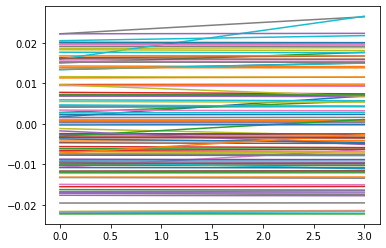

In [13]:
model_params_nonoise.loc[range(4), range(100)].plot(legend=False)

<AxesSubplot:>

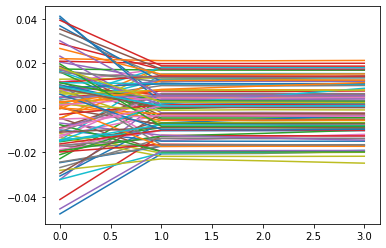

In [14]:
model_params_withnoise.loc[range(4), range(100)].plot(legend=False)

So for the weights it's just an initial jump. But again, it only happens on the first iteration, and it only happens with noise. Why?